In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import json
import os
import pickle

2025-07-30 17:59:40.975803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 17:59:40.975832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 17:59:40.976880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 17:59:40.982542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 17:59:41.890171: W tensorflow/compiler/tf2

In [2]:
# Load processed data to avoid re-running the data processing pipeline
data_dir = 'processed_data'
if not os.path.exists(data_dir):
    print("Processed data not found. Running data processing first...")
    import subprocess
    subprocess.run(['python', 'data_processing.py'])

# Load the processed data
print("Loading processed data...")

# Load numpy arrays
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

# Load metadata
with open(os.path.join(data_dir, 'data_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Load complete dataset for additional info
complete_data_file = os.path.join(data_dir, 'composer_classification_data.pkl')
if os.path.exists(complete_data_file):
    with open(complete_data_file, 'rb') as f:
        complete_data = pickle.load(f)
    composer_names = complete_data.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])
else:
    composer_names = metadata.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])

print(f"Data loaded successfully!")
print(f"Composers: {composer_names}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Loading processed data...
Data loaded successfully!
Composers: ['Bach' 'Beethoven' 'Chopin' 'Mozart']
X_train shape: (976, 128, 1000)
X_val shape: (326, 128, 1000)
X_test shape: (326, 128, 1000)
y_train shape: (976,)
y_val shape: (326,)
y_test shape: (326,)


In [3]:
# Prepare data for RNN (transpose for time series)
# From (samples, 128, time_steps) to (samples, time_steps, 128)
X_train_rnn = np.transpose(X_train, (0, 2, 1))
X_val_rnn = np.transpose(X_val, (0, 2, 1))
X_test_rnn = np.transpose(X_test, (0, 2, 1))

print("Data prepared for RNN:")
print(f"X_train_rnn shape: {X_train_rnn.shape}")
print(f"X_val_rnn shape: {X_val_rnn.shape}")
print(f"X_test_rnn shape: {X_test_rnn.shape}")

# Create data dictionary for easy access
rnn_data = {
    'X_train': X_train_rnn,
    'X_val': X_val_rnn,
    'X_test': X_test_rnn,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'composer_names': composer_names
}

Data prepared for RNN:
X_train_rnn shape: (976, 1000, 128)
X_val_rnn shape: (326, 1000, 128)
X_test_rnn shape: (326, 1000, 128)


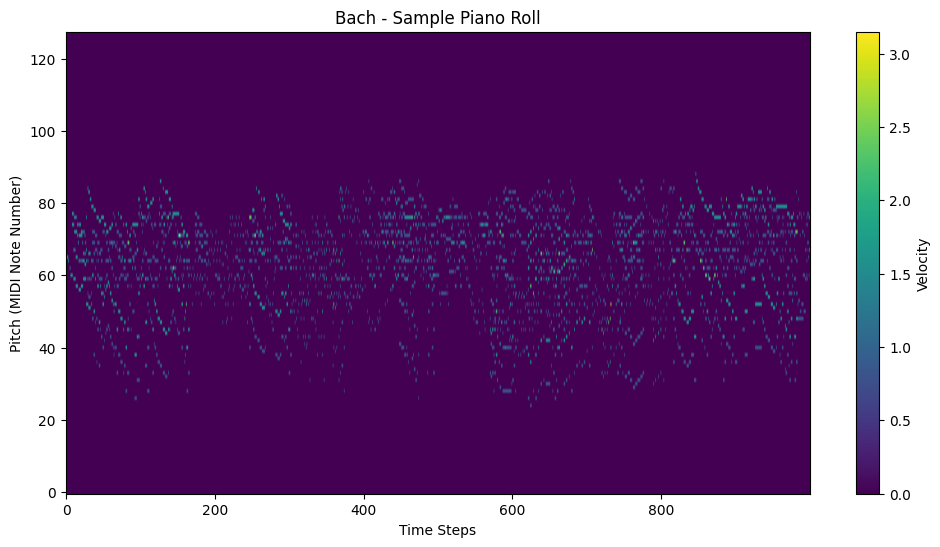

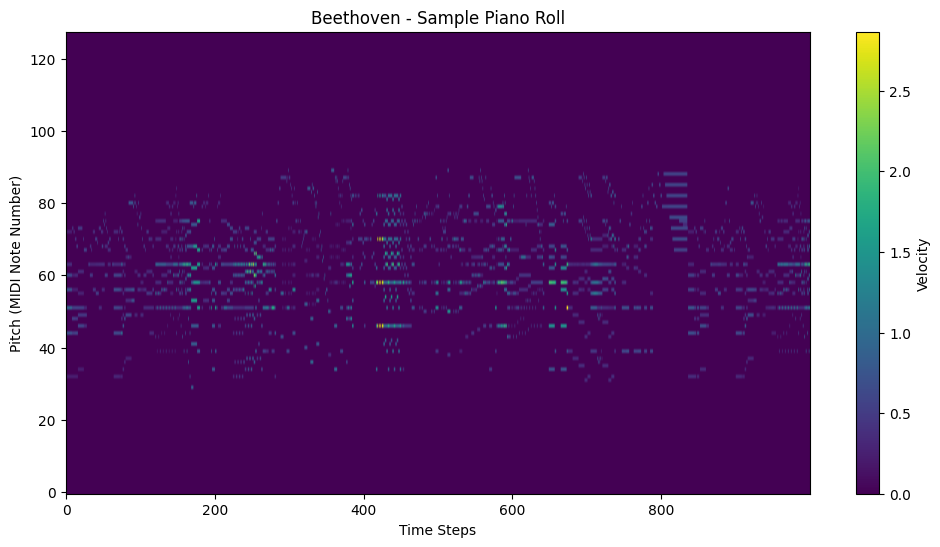

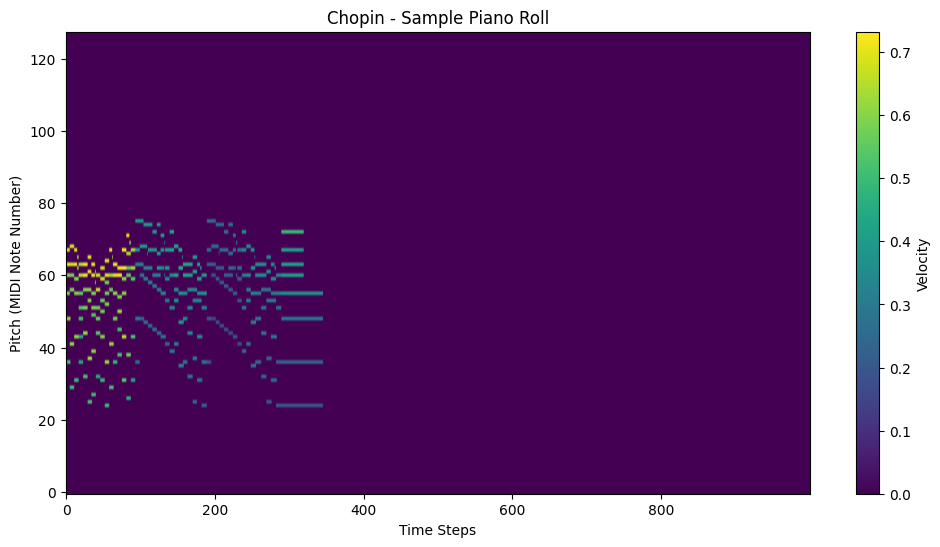

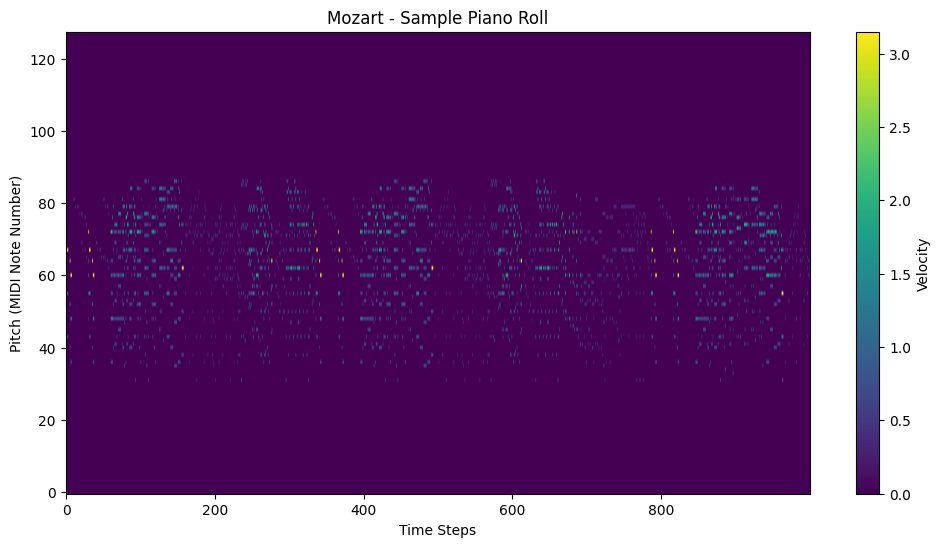

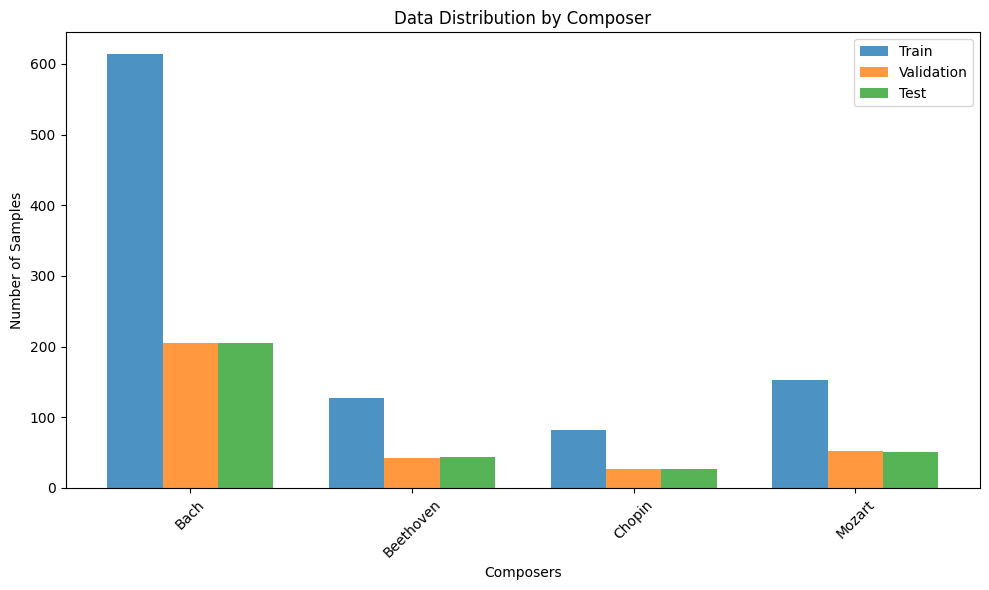

In [4]:
# Visualize a sample piano roll
def plot_piano_roll(piano_roll, title="Piano Roll Sample"):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.title(title)
    plt.show()

# Plot samples from each composer
for i, composer in enumerate(composer_names):
    # Find first sample from this composer
    composer_indices = np.where(rnn_data['y_train'] == i)[0]
    if len(composer_indices) > 0:
        sample_idx = composer_indices[0]
        # Transpose back for visualization (RNN data is transposed)
        piano_roll = np.transpose(rnn_data['X_train'][sample_idx], (1, 0))
        plot_piano_roll(piano_roll, f"{composer} - Sample Piano Roll")

# Analyze data distribution
plt.figure(figsize=(10, 6))
train_dist = np.bincount(rnn_data['y_train'])
val_dist = np.bincount(rnn_data['y_val'])
test_dist = np.bincount(rnn_data['y_test'])

x = np.arange(len(composer_names))
width = 0.25

plt.bar(x - width, train_dist, width, label='Train', alpha=0.8)
plt.bar(x, val_dist, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_dist, width, label='Test', alpha=0.8)

plt.xlabel('Composers')
plt.ylabel('Number of Samples')
plt.title('Data Distribution by Composer')
plt.xticks(x, composer_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Define model parameters (time_steps, features)
input_shape = rnn_data['X_train'].shape[1:]
num_classes = len(composer_names)
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Build simple RNN model
def create_simple_rnn_model(input_shape, num_classes):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First LSTM layer
        layers.LSTM(128, return_sequences=True, dropout=0.2),
        
        # Second LSTM layer
        layers.LSTM(64, return_sequences=False, dropout=0.2),
        
        # Dense layers
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_simple_rnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Input shape: (1000, 128)
Number of classes: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 183204 (715.64 KB)
Trainable params: 183204 (715.64 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [6]:
# Set training parameters
epochs = 20
batch_size = 32

# Train the model
print("Starting training...")
history = model.fit(
    rnn_data['X_train'], 
    rnn_data['y_train'],
    validation_data=(rnn_data['X_val'], rnn_data['y_val']),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/20


2025-07-30 17:59:51.129456: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499712000 exceeds 10% of free system memory.


31/31 [==============================] - ETA: 0s - loss: 1.1862 - accuracy: 0.6066

2025-07-30 18:00:10.525711: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 166912000 exceeds 10% of free system memory.


31/31 [==============================] - 21s 628ms/step - loss: 1.1862 - accuracy: 0.6066 - val_loss: 0.9969 - val_accuracy: 0.6166
Epoch 2/20
31/31 [==============================] - 18s 576ms/step - loss: 0.9964 - accuracy: 0.6270 - val_loss: 0.9629 - val_accuracy: 0.6227
Epoch 3/20
31/31 [==============================] - 17s 562ms/step - loss: 0.9508 - accuracy: 0.6609 - val_loss: 0.9487 - val_accuracy: 0.6411
Epoch 4/20
31/31 [==============================] - 18s 597ms/step - loss: 0.9343 - accuracy: 0.6557 - val_loss: 0.9414 - val_accuracy: 0.6442
Epoch 5/20
31/31 [==============================] - 19s 630ms/step - loss: 0.8895 - accuracy: 0.6885 - val_loss: 0.9324 - val_accuracy: 0.6718
Epoch 6/20
31/31 [==============================] - 19s 609ms/step - loss: 0.9311 - accuracy: 0.6588 - val_loss: 0.9479 - val_accuracy: 0.6626
Epoch 7/20
31/31 [==============================] - 17s 565ms/step - loss: 0.8930 - accuracy: 0.6906 - val_loss: 0.9355 - val_accuracy: 0.6472
Epoch 8/20

2025-07-30 18:05:52.156913: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 166912000 exceeds 10% of free system memory.


Test Accuracy: 0.6748
Test Loss: 0.9124


2025-07-30 18:05:54.377542: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 166912000 exceeds 10% of free system memory.


11/11 [==============================] - 2s 168ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.74      0.95      0.83       205
   Beethoven       0.36      0.30      0.33        43
      Chopin       0.00      0.00      0.00        27
      Mozart       0.52      0.24      0.32        51

    accuracy                           0.67       326
   macro avg       0.41      0.37      0.37       326
weighted avg       0.59      0.67      0.62       326



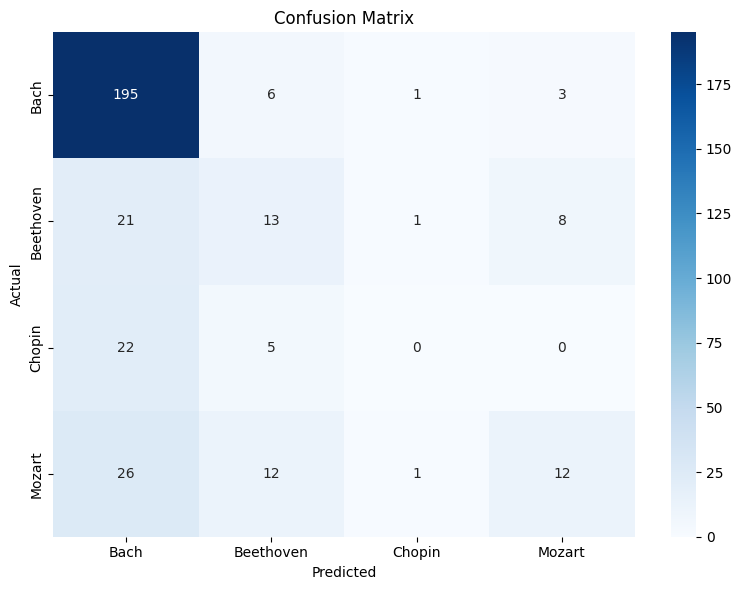

In [7]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(rnn_data['X_test'], rnn_data['y_test'], verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(rnn_data['X_test'])
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(rnn_data['y_test'], y_pred_classes, 
                          target_names=composer_names))

# Confusion matrix
cm = confusion_matrix(rnn_data['y_test'], y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

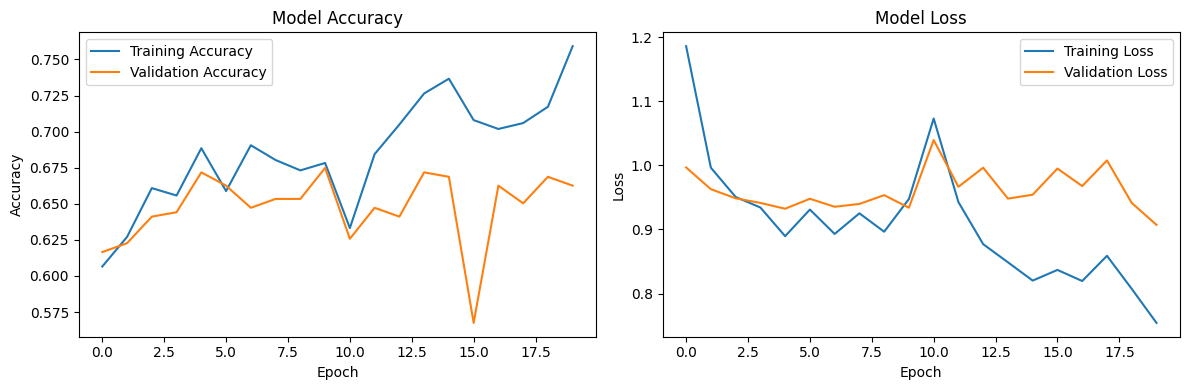

Final Training Accuracy: 0.7592
Final Validation Accuracy: 0.6626
Final Training Loss: 0.7541
Final Validation Loss: 0.9072


In [8]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [20]:
# Analyze the class distribution
print("Class Distribution Analysis:")
for i, composer in enumerate(composer_names):
    train_count = np.sum(rnn_data['y_train'] == i)
    val_count = np.sum(rnn_data['y_val'] == i)
    test_count = np.sum(rnn_data['y_test'] == i)
    print(f"{composer}: Train={train_count}, Val={val_count}, Test={test_count}")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(rnn_data['y_train']),
    y=rnn_data['y_train']
)
class_weight_dict = dict(zip(np.unique(rnn_data['y_train']), class_weights))

print(f"\nClass weights: {class_weight_dict}")

Class Distribution Analysis:
Bach: Train=614, Val=205, Test=205
Beethoven: Train=127, Val=42, Test=43
Chopin: Train=82, Val=27, Test=27
Mozart: Train=153, Val=52, Test=51

Class weights: {0: 0.3973941368078176, 1: 1.921259842519685, 2: 2.975609756097561, 3: 1.5947712418300655}


In [21]:
# Create a robust model that handles imbalanced data well
def create_robust_model(input_shape, num_classes):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Batch normalization for better training
        layers.BatchNormalization(),
        
        # First LSTM layer with moderate complexity
        layers.LSTM(128, return_sequences=True, dropout=0.3),
        
        # Second LSTM layer
        layers.LSTM(64, return_sequences=False, dropout=0.3),
        
        # Dense layers with regularization
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Get model parameters
input_shape = X_train_rnn.shape[1:]
num_classes = len(composer_names)

print(f"Model parameters:")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Create model
robust_model = create_robust_model(input_shape, num_classes)

# Compile with balanced class weights
robust_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

robust_model.summary()

Model parameters:
Input shape: (1000, 128)
Number of classes: 4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Bat  (None, 1000, 128)         512       
 chNormalization)                                                
                                                                 
 lstm_11 (LSTM)              (None, 1000, 128)         131584    
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_10 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                        

In [22]:
# Set up callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_robust_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the robust model
print("Training robust model with balanced class weights...")
history_robust = robust_model.fit(
    X_train_rnn, 
    y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Training robust model with balanced class weights...
Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.7042 - accuracy: 0.3207
Epoch 1: val_accuracy improved from -inf to 0.13804, saving model to best_robust_model.h5
31/31 [==============================] - 29s 839ms/step - loss: 1.7042 - accuracy: 0.3207 - val_loss: 1.4061 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 2/50


/home/qinyaomou/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 1.5042 - accuracy: 0.3873
Epoch 2: val_accuracy did not improve from 0.13804
31/31 [==============================] - 22s 717ms/step - loss: 1.5042 - accuracy: 0.3873 - val_loss: 1.4221 - val_accuracy: 0.1288 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 1.4421 - accuracy: 0.4180
Epoch 3: val_accuracy did not improve from 0.13804
31/31 [==============================] - 23s 732ms/step - loss: 1.4421 - accuracy: 0.4180 - val_loss: 1.4420 - val_accuracy: 0.1258 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.4744
Epoch 4: val_accuracy did not improve from 0.13804
31/31 [==============================] - 22s 710ms/step - loss: 1.3052 - accuracy: 0.4744 - val_loss: 1.4356 - val_accuracy: 0.1227 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 1.2692 - accuracy: 0.4365
Epoch 5: val_accuracy improved from 0.13804 to 

Robust Model - Test Accuracy: 0.6043
Robust Model - Test Loss: 1.2282
11/11 [==============================] - 3s 175ms/step

Robust Model - Classification Report:
              precision    recall  f1-score   support

        Bach       0.78      0.83      0.81       205
   Beethoven       0.24      0.23      0.24        43
      Chopin       0.09      0.04      0.05        27
      Mozart       0.29      0.31      0.30        51

    accuracy                           0.60       326
   macro avg       0.35      0.35      0.35       326
weighted avg       0.58      0.60      0.59       326



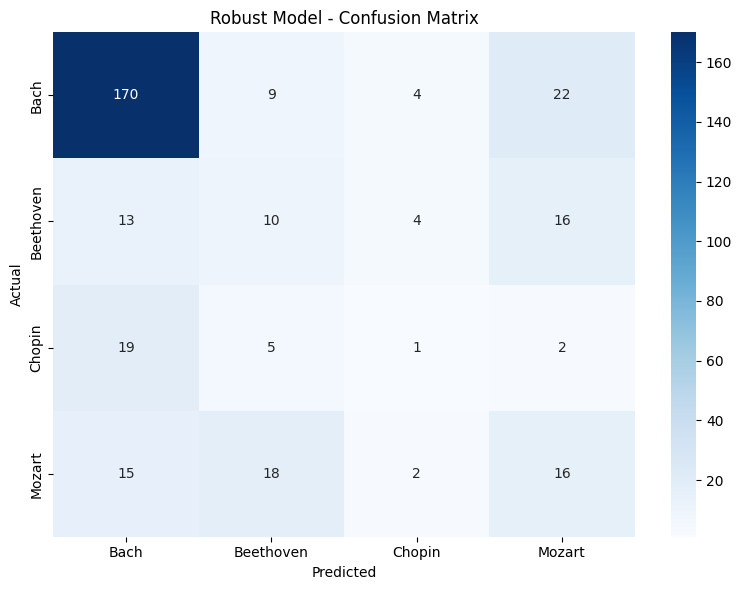


Per-Class Performance Analysis:
Bach: 0.8293 (205 samples)
Beethoven: 0.2326 (43 samples)
Chopin: 0.0370 (27 samples)
Mozart: 0.3137 (51 samples)


In [23]:
# Evaluate robust model
test_loss_robust, test_accuracy_robust = robust_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Robust Model - Test Accuracy: {test_accuracy_robust:.4f}")
print(f"Robust Model - Test Loss: {test_loss_robust:.4f}")

# Make predictions
y_pred_robust = robust_model.predict(X_test_rnn)
y_pred_classes_robust = np.argmax(y_pred_robust, axis=1)

# Classification report
print("\nRobust Model - Classification Report:")
print(classification_report(y_test, y_pred_classes_robust, 
                          target_names=composer_names))

# Confusion matrix
cm_robust = confusion_matrix(y_test, y_pred_classes_robust)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_robust, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('Robust Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Per-class analysis
print("\nPer-Class Performance Analysis:")
for i, composer in enumerate(composer_names):
    class_mask = y_test == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(y_pred_classes_robust[class_mask] == y_test[class_mask])
        class_samples = np.sum(class_mask)
        print(f"{composer}: {class_accuracy:.4f} ({class_samples} samples)")

In [24]:
# Implement data augmentation for minority classes
def augment_piano_roll(piano_roll, augmentation_type='noise'):
    """Simple augmentation techniques"""
    if augmentation_type == 'noise':
        # Add small random noise
        noise = np.random.normal(0, 0.02, piano_roll.shape)
        augmented = piano_roll + noise
        augmented = np.clip(augmented, 0, 1)
    
    elif augmentation_type == 'time_shift':
        # Circular time shift
        shift = np.random.randint(-20, 20)
        augmented = np.roll(piano_roll, shift, axis=0)
    
    elif augmentation_type == 'velocity_scale':
        # Scale velocities slightly
        scale = np.random.uniform(0.9, 1.1)
        augmented = piano_roll * scale
        augmented = np.clip(augmented, 0, 1)
    
    else:
        augmented = piano_roll.copy()
    
    return augmented

def augment_minority_classes(X, y, target_samples_per_class=200):
    """Augment minority classes to balance dataset"""
    X_augmented = []
    y_augmented = []
    
    for class_idx in range(len(composer_names)):
        class_indices = np.where(y == class_idx)[0]
        current_samples = len(class_indices)
        
        # Add original samples
        X_augmented.extend(X[class_indices])
        y_augmented.extend([class_idx] * current_samples)
        
        # Augment minority classes
        if current_samples < target_samples_per_class:
            needed_samples = target_samples_per_class - current_samples
            augmentation_types = ['noise', 'time_shift', 'velocity_scale']
            
            for _ in range(needed_samples):
                # Randomly select a sample from this class
                sample_idx = np.random.choice(class_indices)
                sample = X[sample_idx].copy()
                
                # Apply random augmentation
                aug_type = np.random.choice(augmentation_types)
                augmented_sample = augment_piano_roll(sample, aug_type)
                X_augmented.append(augmented_sample)
                y_augmented.append(class_idx)
    
    return np.array(X_augmented), np.array(y_augmented)

# Apply augmentation
print("Applying data augmentation for minority classes...")
X_train_aug, y_train_aug = augment_minority_classes(X_train_rnn, y_train)

print(f"Original training samples: {len(X_train_rnn)}")
print(f"Augmented training samples: {len(X_train_aug)}")

# Check new distribution
for i, composer in enumerate(composer_names):
    count = np.sum(y_train_aug == i)
    print(f"{composer}: {count} samples")

Applying data augmentation for minority classes...
Original training samples: 976
Augmented training samples: 1214
Bach: 614 samples
Beethoven: 200 samples
Chopin: 200 samples
Mozart: 200 samples


In [25]:
# Create model for augmented data
augmented_model = create_robust_model(input_shape, num_classes)
augmented_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with augmented data
print("Training model with augmented data...")
history_augmented = augmented_model.fit(
    X_train_aug, 
    y_train_aug,
    validation_data=(X_val_rnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate augmented model
test_loss_aug, test_accuracy_aug = augmented_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Augmented Model - Test Accuracy: {test_accuracy_aug:.4f}")

y_pred_aug = augmented_model.predict(X_test_rnn)
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)

print("\nAugmented Model - Classification Report:")
print(classification_report(y_test, y_pred_classes_aug, 
                          target_names=composer_names))

Training model with augmented data...
Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.6329 - accuracy: 0.4077
Epoch 1: val_accuracy did not improve from 0.65951
38/38 [==============================] - 32s 766ms/step - loss: 1.6329 - accuracy: 0.4077 - val_loss: 1.3119 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.5379
Epoch 2: val_accuracy did not improve from 0.65951
38/38 [==============================] - 24s 623ms/step - loss: 1.2727 - accuracy: 0.5379 - val_loss: 1.2894 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.5857
Epoch 3: val_accuracy did not improve from 0.65951
38/38 [==============================] - 23s 604ms/step - loss: 1.1422 - accuracy: 0.5857 - val_loss: 1.3338 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 1.0790 - accuracy: 0.612

/home/qinyaomou/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7381
Epoch 14: val_accuracy did not improve from 0.66564
38/38 [==============================] - 22s 591ms/step - loss: 0.8121 - accuracy: 0.7381 - val_loss: 1.3439 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 15/50
38/38 [==============================] - ETA: 0s - loss: 0.8409 - accuracy: 0.7265
Epoch 15: val_accuracy did not improve from 0.66564
38/38 [==============================] - 22s 591ms/step - loss: 0.8409 - accuracy: 0.7265 - val_loss: 1.0694 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 16/50
38/38 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.7306
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_accuracy improved from 0.66564 to 0.66871, saving model to best_robust_model.h5
38/38 [==============================] - 23s 594ms/step - loss: 0.8514 - accuracy: 0.7306 - val_loss: 1.0471 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 17/50
38/3